In [1]:
import os
import os.path as osp
from os import environ
import time

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import CitationFull, Coauthor, WebKB, LastFMAsia, Twitch
from dblp_fairness import DBLPFairness
from say_no import SayNo
from nifty import Nifty

from gcn_conv import GCNConv
from torch_geometric.utils import negative_sampling, to_dense_adj, add_remaining_self_loops, is_undirected, dense_to_sparse, subgraph, contains_self_loops
from torch_geometric.data import Data
from connected_classes import ConnectedClasses, LargestConnectedComponents, LargestBiconnectedComponents

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import math
import numpy as np
import networkx as nx
import re

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error

In [2]:
environ['CUDA_LAUNCH_BLOCKING'] = "1"
dataset_name = environ.get('dataset_name', 'DBLPFairness')
conv_type = environ.get('conv_type', 'sym')
k = int(environ.get('k', '2'))
seeds = [34, 87, 120, 11, 93, 24, 25, 56, 49, 54]
inspect_deviations = False

In [3]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, conv_type):
        super().__init__()
        self.convs = torch.nn.ModuleList([GCNConv(in_channels, hidden_channels, conv=conv_type)] + \
                                [GCNConv(hidden_channels, hidden_channels, conv=conv_type) for i in range(k - 2)] + \
                                [GCNConv(hidden_channels, out_channels, conv=conv_type)])

    def encode(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index).relu()
        return self.convs[-1](x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return prob_adj

In [4]:
def train(model, train_data):
    model.train()
    optimizer.zero_grad()
    
    x = train_data.x
    z = model.encode(x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
        
    return loss

@torch.no_grad()
def test(model, data):
    model.eval()
    x = data.x
    z = model.encode(x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [5]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
from typing import List, Union

from torch_geometric.data import Data, HeteroData
from torch_geometric.transforms import BaseTransform

class NormalizeFeatures(BaseTransform):
    def __init__(self, attrs: List[str] = ["x"]):
        self.attrs = attrs

    def __call__(self, data: Data) -> Data:
        for store in data.stores:
            for key, value in store.items(*self.attrs):
                if value.numel() > 0:
                    min_values = value.min(dim=0)[0]
                    max_values = value.max(dim=0)[0]
                    store[key] = 2*(value - min_values).div(max_values-min_values) - 1
        return data

In [7]:
def load_dataset(dataset_name):    
    if dataset_name in ["Cora", "Cora_ML", "CiteSeer", "DBLP", "PubMed"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'CitationFull')
        dataset = CitationFull(path, name=dataset_name, transform=transform)
    elif dataset_name in ["CS", "Physics"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'Coauthor')
        dataset = Coauthor(path, name=dataset_name, transform=transform)
    elif dataset_name in ["LastFMAsia"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'LastFMAsia')
        dataset = LastFMAsia(path, transform=transform)
        dataset.name = "LastFMAsia"
    elif dataset_name in ["DE", "EN", "FR"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'Twitch')
        dataset = Twitch(path, name=dataset_name, transform=transform)
    elif dataset_name in ["DBLPFairness"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'DBLPFairness')
        dataset = DBLPFairness(path, transform=transform)
        dataset.name = "DBLPFairness"
    elif dataset_name in ["Pokec-z", "Pokec-n", "NBA"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'SayNo')
        dataset = SayNo(path, name=dataset_name, transform=transform)
    elif dataset_name in ["Credit", "German"]:
        transform = T.Compose([ 
            ConnectedClasses(),
            NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        path = osp.join('.', 'data', 'Nifty')
        dataset = Nifty(path, name=dataset_name, transform=transform)
    else:
        raise ValueError

    return dataset

In [8]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

dataset = load_dataset(dataset_name)
test_data = dataset[0][2]
num_labels = int(test_data.y.max()) + 1
print(test_data.edge_label_index.size())

x_list = [[[] for _ in range(len(seeds))] for _ in range(num_labels)]
y_list = [[[] for _ in range(len(seeds))] for _ in range(num_labels)]
pcc_list = []
nrmse_list = []
auc_list = []

feat_sim_list = []
deg_sim_list = []
colors_list = []

fairness_scores = []

for seed_idx, seed in enumerate(seeds):
    seed_everything(0)
    
    dataset = load_dataset(dataset_name)
    train_data, val_data, test_data = dataset[0]
    
    seed_everything(seed)
    
    num_feat = dataset.num_features
    model = Net(num_feat, 128, 64, conv_type).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    x_pcc = []
    y_pcc = []
    
    x_nrmse = []
    y_nrmse = []

    best_val_auc = final_test_auc = 0
    for epoch in range(1, 101):
        loss = train(model, train_data)
        val_auc = test(model, val_data)
        test_auc = test(model, test_data)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            final_test_auc = test_auc

    print(f'Final Test: {final_test_auc:.4f}')
    auc_list.append(final_test_auc)
    
    model.eval()
    x = test_data.x
    rep = model.encode(x, test_data.edge_index)
    if dataset_name in ["DBLPFairness", "NBA", "German"]:
        final_probs = model.decode_all(rep).detach().cpu()

    z = x
    for conv in model.convs:
        z = z @ conv.lin.weight.detach().t()
    taylor_rep = torch.zeros_like(z)
    
    test_edge_index = add_remaining_self_loops(test_data.edge_index, num_nodes=test_data.x.size(0))[0]
    print("Is undirected?", is_undirected(test_edge_index))
    print("Contains self-loops?", contains_self_loops(test_edge_index))
    
    if inspect_deviations:
        feat_rep = torch.zeros_like(z)
        deg_sim = torch.zeros((test_data.x.size(0), test_data.x.size(0))).to(device)
    
    for c in range(int(test_data.y.max()) + 1):
        c_mask = torch.nonzero(test_data.y.flatten() == c).flatten()
        c_edge_index = subgraph(c_mask, test_edge_index, relabel_nodes=True, num_nodes=test_data.x.size(0))[0]
        c_section = to_dense_adj(c_edge_index)[0]

        deg_i = c_section.sum(dim=1)
        deg_j = c_section.sum(dim=0)

        if conv_type == "sym":
            eigv_i = torch.sqrt(deg_i / deg_i.sum())
            eigv_j = torch.sqrt(deg_j / deg_j.sum())
        else:
            eigv_i = torch.ones_like(deg_i)
            eigv_j = deg_j / deg_j.sum()

        taylor_rep[c_mask] = eigv_i.reshape(-1, 1) @ eigv_j.reshape(1, -1) @ z[c_mask]
        
        if inspect_deviations:
            feat_rep[c_mask] = torch.sqrt(torch.ones_like(deg_i) / deg_i.sum()).reshape(-1, 1) @ eigv_j.reshape(1, -1) @ z[c_mask]
            prod = torch.sqrt(deg_i.reshape(-1, 1) @ deg_j.reshape(1, -1))
            for i, idx in enumerate(c_mask):
                deg_sim[idx, c_mask] = prod[i]
            
    if inspect_deviations:
        label_adj = to_dense_adj(test_data.edge_label_index, max_num_nodes=test_data.x.size(0))[0]
        deg_sim = deg_sim.cpu()
    
    if dataset_name in ["DBLPFairness", "NBA", "German"]:
        label_adj = to_dense_adj(test_data.edge_label_index, max_num_nodes=test_data.x.size(0))[0]
        pred_probs = model.decode_all(taylor_rep).detach().cpu()

    for c in range(int(test_data.y.max()) + 1):
        c_mask = torch.nonzero(test_data.y.flatten() == c).flatten()
        c_edge_label_index = subgraph(c_mask, test_data.edge_label_index, num_nodes=test_data.x.size(0))[0]
        
        x = model.decode(rep, c_edge_label_index).detach().cpu().numpy()
        y = model.decode(taylor_rep, c_edge_label_index).detach().cpu().numpy()
        
        if len(x) <= 1:
            continue
        
        rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)
        if dataset_name in ["DBLPFairness", "NBA", "German"] and rho[0] < 0:
            continue
        y *= rho[0]

        x_list[c][seed_idx] = x.tolist()
        y_list[c][seed_idx] = y.tolist()
        
        x_pcc.extend(x.tolist())
        y_pcc.extend(y.tolist())
        
        x_nrmse.extend(x.tolist())
        y_nrmse.extend(y.tolist())

        if inspect_deviations:
            c_mask = ((test_data.y.reshape(-1, 1) == c) & (test_data.y.reshape(1, -1) == c)) & (label_adj == 1)
            colors = (x - y).tolist()
            colors_list += colors

            feat_sim = model.decode(feat_rep, c_edge_label_index).detach().cpu()
            feat_sim_list += feat_sim.numpy().tolist()
            deg_sim_list += deg_sim[c_mask].numpy().tolist()
        
        if dataset_name in ["DBLPFairness", "NBA", "German"]:
            c0_mask = (test_data.y.reshape(-1, 1) == c) & (test_data.sens.reshape(-1, 1) == 0)
            c1_mask = (test_data.y.reshape(-1, 1) == c) & (test_data.sens.reshape(-1, 1) == 1)
            c_mask = test_data.y.reshape(-1, 1) == c
            
            c0a_mask = (c0_mask & c_mask.reshape(1, -1)) & (label_adj == 1)
            c1a_mask = (c1_mask & c_mask.reshape(1, -1)) & (label_adj == 1)
            ca_mask = (c_mask & c_mask.reshape(1, -1)) & (label_adj == 1)
            
            for probs in [final_probs, pred_probs * rho[0]]:
                total_0 = torch.sigmoid(probs[c0a_mask]).mean()
                total_1 = torch.sigmoid(probs[c1a_mask]).mean()
                fairness_scores.append(abs(total_0.item() - total_1.item()))
    
    pcc, _ = pearsonr(x_pcc, y_pcc)
    pcc_list.append(pcc)
    
    nrmse = mean_squared_error(x_nrmse, y_nrmse, squared=False)
    nrmse = nrmse / (max(x_nrmse) - min(x_nrmse))
    nrmse_list.append(nrmse)

torch.Size([2, 1490])
Final Test: 0.7748
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7908
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7700
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7795
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7739
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7734
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7828
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7701
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7816
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


Final Test: 0.7799
Is undirected? True
Contains self-loops? True


<ipython-input-8-d7d4dabdad51>:111: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  rho, _, _, _ = np.linalg.lstsq(y[:,np.newaxis], x)


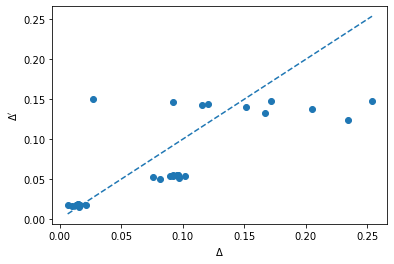

In [9]:
if dataset_name in ["DBLPFairness", "NBA", "German"]:
    plt.scatter(fairness_scores[::2], fairness_scores[1::2])
    
    min_xy = min(fairness_scores[::2] + fairness_scores[1::2])
    max_xy = max(fairness_scores[::2] + fairness_scores[1::2])
    data = [min_xy, max_xy]
    
    plt.plot(data, data, '--')
    
    plt.xlabel(r"$\Delta$")
    plt.ylabel(r"$\Delta'$")
    plt.savefig("plots/{}_{}_{}_{}.png".format(dataset.name, conv_type, k, "delta"))

In [10]:
if inspect_deviations:
    feat_sim_list = np.array(feat_sim_list)
    deg_sim_list = np.array(deg_sim_list)
    colors_list = np.abs(np.array(colors_list))

    tau = np.percentile(colors_list, 0)

    print("Feature Similarity - Deviation:", spearmanr(feat_sim_list[colors_list > tau], colors_list[colors_list > tau])[0])
    print("Degree Product - Deviation:", spearmanr(deg_sim_list[colors_list > tau], colors_list[colors_list > tau])[0])

    plt.scatter(feat_sim_list[colors_list > tau], colors_list[colors_list > tau])
    plt.xlabel("Feature similarity")
    plt.ylabel("Absolute deviation")
    plt.show()

    plt.scatter(deg_sim_list[colors_list > tau], colors_list[colors_list > tau])
    plt.xlabel("Degree product")
    plt.ylabel("Absolute deviation")
    plt.show()

    plt.scatter(feat_sim_list[colors_list > tau], deg_sim_list[colors_list > tau], c=colors_list[colors_list > tau])
    plt.xlabel("Feature similarity")
    plt.ylabel("Degree product")
    plt.colorbar()
    plt.show()

In [11]:
auc_all = torch.tensor(auc_list)
auc_avg = auc_all.mean().item()
auc_std = auc_all.std().item()
auc_str = "{0:.3f} ± ".format(auc_avg) + "{0:.3f}".format(auc_std)
print(auc_str)

0.778 ± 0.007


In [12]:
pcc_all = torch.tensor(pcc_list)
pcc_avg = pcc_all.mean().item()
pcc_std = pcc_all.std().item()
pcc_str = "{0:.3f} ± ".format(pcc_avg) + "{0:.3f}".format(pcc_std)
print(pcc_str)

0.540 ± 0.024


In [13]:
nrmse_all = torch.tensor(nrmse_list)
nrmse_avg = nrmse_all.mean().item()
nrmse_std = nrmse_all.std().item()
nrmse_str = "{0:.3f} ± ".format(nrmse_avg) + "{0:.3f}".format(nrmse_std)
print(nrmse_str)

0.082 ± 0.009


In [14]:
plot_title = " ".join([w.upper() for w in re.split('_| ', dataset.name)])

with open("results.csv", "a") as results_file:
    results_file.write(plot_title + ",")
    results_file.write(nrmse_str + ",")
    results_file.write(pcc_str + ",")
    results_file.write(auc_str + "\n")

In [15]:
plotly_objs = []

min_avg = 0
max_avg = 0

test_N = 0
test_B = 0

for c in range(len(x_list)):

    x_all = torch.tensor(x_list[c])
    y_all = torch.tensor(y_list[c])
    
    test_N += int(x_all.numel() / len(seeds))
    if x_all.numel() > 0:
        test_B += 1

    if x_all.numel() == 0:
        continue

    for i in range(len(x_all)):
        x, y = x_all[i], y_all[i]

    x_avg = x_all.mean(dim=0)
    y_avg = y_all.mean(dim=0)
    
    min_avg = min(min_avg, x_avg.min().item())
    min_avg = min(min_avg, y_avg.min().item())
    max_avg = max(max_avg, x_avg.max().item())
    max_avg = max(max_avg, y_avg.max().item())
    
    x_range = x_all.max(dim=0).values - x_all.min(dim=0).values
    y_range = y_all.max(dim=0).values - y_all.min(dim=0).values
    marker_size = (0.1 * (x_range ** 2 + y_range ** 2)).tolist()

    plotly_objs.extend([
        go.Scatter(
            x=x_avg.tolist(),
            y=y_avg.tolist(),
            mode='markers',
            showlegend=False,
            marker=dict(size=marker_size,
                        sizemode='area',
                        sizeref=2.*max(marker_size)/(30.**2))
        )
    ])

diag_y = [min_avg, max_avg]
diag_x = diag_y

plotly_objs.append(go.Scatter(
            x=diag_x,
            y=diag_y,
            mode='lines',
            line={'dash': 'dash', 'color': 'black'},
            showlegend=False
        ))

# avoid loading mathjax text
fig=px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.write_image("plots/{}_{}_{}.png".format(dataset.name, conv_type, k))
time.sleep(2)

plot_title += " (N = {}, B = {})".format(test_N, test_B)
axis_titles = [r"\textrm{ link prediction score}$", r"$\textrm{Theoretic link prediction score}$"]
auc_annot = r"\textrm{ test AUC} = " + auc_str + r"$"
if conv_type == "sym":
    axis_titles[0] = r"$\Phi_s" + axis_titles[0]
    auc_annot = r"$\Phi_s" + auc_annot
else:
    axis_titles[0] = r"$\Phi_r" + axis_titles[0]
    auc_annot = r"$\Phi_r" + auc_annot

fig = go.Figure(plotly_objs).update_layout(
    xaxis_title=axis_titles[0],
    yaxis_title=axis_titles[1]
)
fig.update_layout(title_text=plot_title, title_x=0.5)
fig.update_layout(
    margin=dict(l=20, r=20, t=30, b=20),
)
fig.add_annotation(dict(x=0.6,
                        y=0.25,
                        text=r"$\textrm{NRMSE} = " + nrmse_str + r"$",
                        showarrow=False,
                        textangle=0,
                        xanchor='left',
                        xref="paper",
                        yref="paper"))
fig.add_annotation(dict(x=0.6,
                        y=0.2,
                        text=r"$r = {}$".format(pcc_str),
                        showarrow=False,
                        textangle=0,
                        xanchor='left',
                        xref="paper",
                        yref="paper"))
fig.add_annotation(dict(x=0.6,
                        y=0.15,
                        text=auc_annot,
                        showarrow=False,
                        textangle=0,
                        xanchor='left',
                        xref="paper",
                        yref="paper"))
fig.write_image("plots/{}_{}_{}.png".format(dataset.name, conv_type, k))

In [16]:
with torch.no_grad():
    torch.cuda.empty_cache()